```
Copyright 2020 The IREE Authors

Licensed under the Apache License v2.0 with LLVM Exceptions.
See https://llvm.org/LICENSE.txt for license information.
SPDX-License-Identifier: Apache-2.0 WITH LLVM-exception
```


# Training and Executing an MNIST Model with IREE

## Overview

This notebook covers installing IREE and using it to train a simple neural network on the MNIST dataset.

## 1. Install and Import IREE

In [1]:
%%capture
!python -m pip install iree-compiler-snapshot iree-runtime-snapshot iree-tools-tf-snapshot -f https://github.com/google/iree/releases

In [2]:
from iree import runtime as ireert
from iree.tf.support import module_utils
from iree.compiler import tf as tfc

In [3]:
# (Temporary) workaround for absl flags...
# https://github.com/googlecolab/colabtools/issues/1323#issuecomment-756343620
import sys
from absl import app
sys.argv = sys.argv[:1]
try:
  app.run(lambda argv: None)
except:
  pass

## 2. Import TensorFlow and Other Dependencies

In [4]:
from matplotlib import pyplot as plt
import numpy as np
import os
import tempfile
import tensorflow as tf

plt.style.use("seaborn-whitegrid")
plt.rcParams["font.family"] = "monospace"
plt.rcParams["figure.figsize"] = [8, 4.5]
plt.rcParams["figure.dpi"] = 150

# Print version information for future notebook users to reference.
print("TensorFlow version: ", tf.__version__)
print("Numpy version: ", np.__version__)

TensorFlow version:  2.5.0
Numpy version:  1.19.5


## 3. Load the MNIST Dataset

In [5]:
# Keras datasets don't provide metadata.
NUM_CLASSES = 10
NUM_ROWS, NUM_COLS = 28, 28

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Reshape into grayscale images:
x_train = np.reshape(x_train, (-1, NUM_ROWS, NUM_COLS, 1))
x_test = np.reshape(x_test, (-1, NUM_ROWS, NUM_COLS, 1))

# Rescale uint8 pixel values into float32 values between 0 and 1:
x_train = x_train.astype(np.float32) / 255
x_test = x_test.astype(np.float32) / 255

# IREE doesn't currently support int8 tensors, so we cast them to int32:
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)

11493376/11490434 [==============================] - 0s 0us/step


Sample image from the dataset:


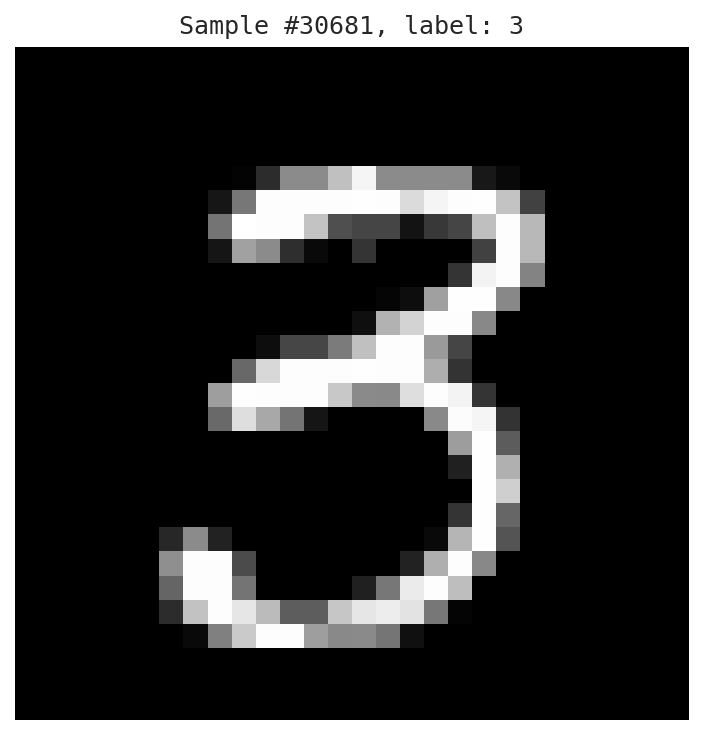

In [6]:
print("Sample image from the dataset:")
sample_index = np.random.randint(x_train.shape[0])
plt.figure(figsize=(5, 5))
plt.imshow(x_train[sample_index].reshape(NUM_ROWS, NUM_COLS), cmap="gray")
plt.title(f"Sample #{sample_index}, label: {y_train[sample_index]}")
plt.axis("off")
plt.tight_layout()

## 4. Create a Simple DNN

MLIR-HLO (the MLIR dialect we use to convert TensorFlow models into assembly that IREE can compile) does not currently support training with a dynamic number of examples, so we compile the model with a fixed batch size (by specifying the batch size in the `tf.TensorSpec`s).

In [7]:
BATCH_SIZE = 32

In [8]:
class TrainableDNN(tf.Module):

  def __init__(self):
    super().__init__()

    # Create a Keras model to train.
    inputs = tf.keras.layers.Input((NUM_COLS, NUM_ROWS, 1))
    x = tf.keras.layers.Flatten()(inputs)
    x = tf.keras.layers.Dense(128)(x)
    x = tf.keras.layers.Activation("relu")(x)
    x = tf.keras.layers.Dense(10)(x)
    outputs = tf.keras.layers.Softmax()(x)
    self.model = tf.keras.Model(inputs, outputs)

    # Create a loss function and optimizer to use during training.
    self.loss = tf.keras.losses.SparseCategoricalCrossentropy()
    self.optimizer = tf.keras.optimizers.SGD(learning_rate=1e-2)
  
  @tf.function(input_signature=[
      tf.TensorSpec([BATCH_SIZE, NUM_ROWS, NUM_COLS, 1])  # inputs
  ])
  def predict(self, inputs):
    return self.model(inputs, training=False)

  # We compile the entire training step by making it a method on the model.
  @tf.function(input_signature=[
      tf.TensorSpec([BATCH_SIZE, NUM_ROWS, NUM_COLS, 1]),  # inputs
      tf.TensorSpec([BATCH_SIZE], tf.int32)  # labels
  ])
  def learn(self, inputs, labels):
    # Capture the gradients from forward prop...
    with tf.GradientTape() as tape:
      probs = self.model(inputs, training=True)
      loss = self.loss(labels, probs)

    # ...and use them to update the model's weights.
    variables = self.model.trainable_variables
    gradients = tape.gradient(loss, variables)
    self.optimizer.apply_gradients(zip(gradients, variables))
    return loss

## 5. Compile the Model with IREE

tf.keras adds a large number of methods to TrainableDNN, and most of them
cannot be compiled with IREE. To get around this we tell IREE exactly which
methods we would like it to compile.

In [9]:
exported_names = ["predict", "learn"]

Choose one of IREE's three backends to compile to. (*Note: Using Vulkan requires installing additional drivers.*)

In [10]:
backend_choice = "llvmaot (CPU)" #@param [ "vmvx (CPU)", "llvmaot (CPU)", "vulkan (GPU/SwiftShader – requires additional drivers) " ]
backend_choice = f"iree_{backend_choice.split(' ')[0]}"

In [11]:
# Compile the TrainableDNN module
compiled_model = module_utils.IreeCompiledModule.create_from_class(
    TrainableDNN, 
    module_utils.BackendInfo(backend_choice), 
    exported_names=exported_names)


FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.


W0710 14:01:50.156594 140472387852160 save.py:1240] FOR KERAS USERS: The object that you are saving contains one or more Keras models or layers. If you are loading the SavedModel with `tf.keras.models.load_model`, continue reading (otherwise, you may ignore the following instructions). Please change your code to save with `tf.keras.models.save_model` or `model.save`, and confirm that the file "keras.metadata" exists in the export directory. In the future, Keras will only load the SavedModels that have this file. In other words, `tf.saved_model.save` will no longer write SavedModels that can be recovered as Keras models (this will apply in TF 2.5).

FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.


INFO:tensorflow:Assets written to: /tmp/tmpfeip9kgo.sm/assets


I0710 14:01:50.206597 140472387852160 builder_impl.py:775] Assets written to: /tmp/tmpfeip9kgo.sm/assets
2021-07-10 14:01:50.433458: I external/org_tensorflow/tensorflow/cc/saved_model/bundle_v2.cc:36] Reading SavedModel from: /tmp/tmpfeip9kgo.sm
2021-07-10 14:01:50.435060: I external/org_tensorflow/tensorflow/cc/saved_model/bundle_v2.cc:59] Reading SavedModel debug info (if present) from: /tmp/tmpfeip9kgo.sm
2021-07-10 14:01:50.490417: I external/org_tensorflow/tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 6. Train the Compiled Model on MNIST

This compiled model is portable, demonstrating that IREE can be used for training on a mobile device. On mobile, IREE has a ~1000 fold binary size advantage over the current TensorFlow solution (which is to use the now-deprecated TF Mobile, as TFLite does not support training at this time).

In [12]:
#@title Benchmark inference and training
print("Inference latency:\n  ", end="")
%timeit -n 100 compiled_model.predict(x_train[:BATCH_SIZE])
print("Training latancy:\n  ", end="")
%timeit -n 100 compiled_model.learn(x_train[:BATCH_SIZE], y_train[:BATCH_SIZE])

Inference latency:
  100 loops, best of 5: 731 µs per loop
Training latancy:
  100 loops, best of 5: 1.91 ms per loop


In [13]:
# Run the core training loop.
losses = []

step = 0
max_steps = x_train.shape[0] // BATCH_SIZE

for batch_start in range(0, x_train.shape[0], BATCH_SIZE):
  if batch_start + BATCH_SIZE > x_train.shape[0]:
    continue

  inputs = x_train[batch_start:batch_start + BATCH_SIZE]
  labels = y_train[batch_start:batch_start + BATCH_SIZE]

  loss = compiled_model.learn(inputs, labels)
  losses.append(loss)

  step += 1
  print(f"\rStep {step:4d}/{max_steps}: loss = {loss:.4f}", end="")

Step 1875/1875: loss = 0.1980

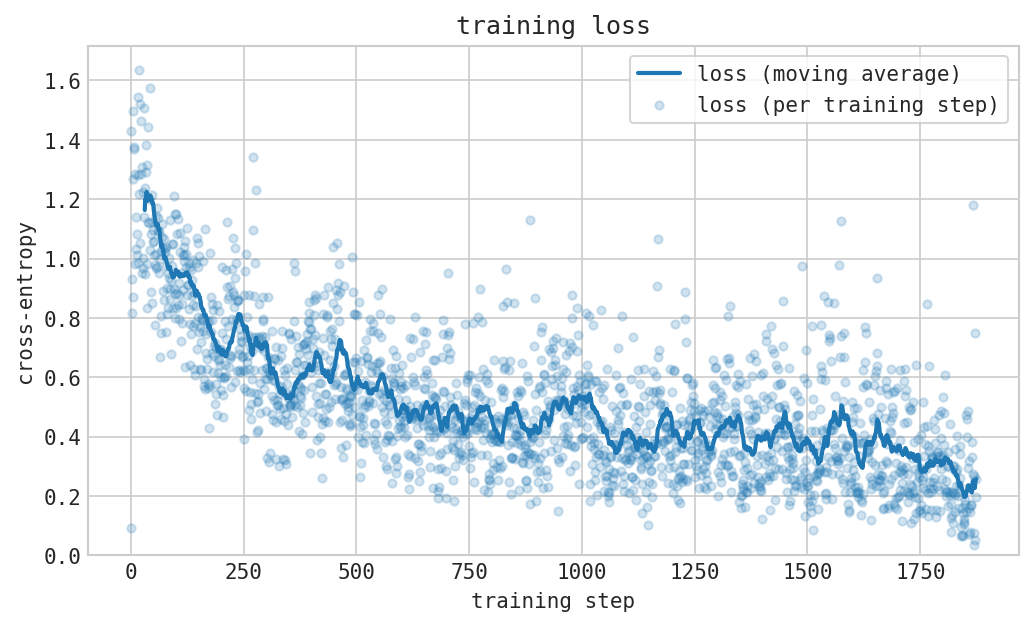

In [14]:
#@title Plot the training results
import bottleneck as bn
smoothed_losses = bn.move_mean(losses, 32)
x = np.arange(len(losses))

plt.plot(x, smoothed_losses, linewidth=2, label='loss (moving average)')
plt.scatter(x, losses, s=16, alpha=0.2, label='loss (per training step)')

plt.ylim(0)
plt.legend(frameon=True)
plt.xlabel("training step")
plt.ylabel("cross-entropy")
plt.title("training loss");

## 7. Evaluate on Heldout Test Examples

In [15]:
#@title Evaluate the network on the test data.
accuracies = []

step = 0
max_steps = x_test.shape[0] // BATCH_SIZE

for batch_start in range(0, x_test.shape[0], BATCH_SIZE):
  if batch_start + BATCH_SIZE > x_test.shape[0]:
    continue

  inputs = x_test[batch_start:batch_start + BATCH_SIZE]
  labels = y_test[batch_start:batch_start + BATCH_SIZE]

  prediction = compiled_model.predict(inputs)
  prediction = np.argmax(prediction, -1)
  accuracies.append(np.sum(prediction == labels) / BATCH_SIZE)

  step += 1
  print(f"\rStep {step:4d}/{max_steps}", end="")
print()

accuracy = np.mean(accuracies)
print(f"Test accuracy: {accuracy:.3f}")

Step  312/312
Test accuracy: 0.904


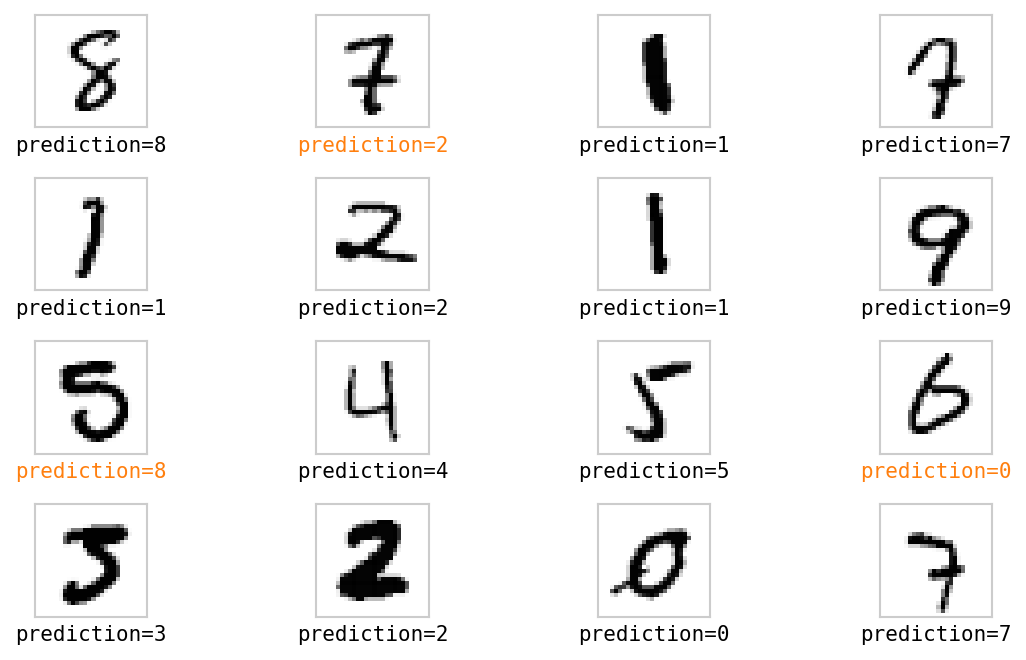

In [16]:
#@title Display inference predictions on a random selection of heldout data
rows = 4
columns = 4
images_to_display = rows * columns
assert BATCH_SIZE >= images_to_display

random_index = np.arange(x_test.shape[0])
np.random.shuffle(random_index)
x_test = x_test[random_index]
y_test = y_test[random_index]

predictions = compiled_model.predict(x_test[:BATCH_SIZE])
predictions = np.argmax(predictions, -1)

fig, axs = plt.subplots(rows, columns)

for i, ax in enumerate(np.ndarray.flatten(axs)):
  ax.imshow(x_test[i, :, :, 0])
  color = "#000000" if predictions[i] == y_test[i] else "#ff7f0e"
  ax.set_xlabel(f"prediction={predictions[i]}", color=color)
  ax.grid(False)
  ax.set_yticks([])
  ax.set_xticks([])

fig.tight_layout()